# Imperfect HWP retardance and fast axis simulation - no meas or matrix noise

Saved residuals to Hamal_residuals_delta_HWP_ang_1_matrix_noise_0_additive_tint_60_sub_tint_1_readout_noise_0_HWP_noise_0.npy
Saved residuals to Hamal_residuals_delta_HWP_ang_2_matrix_noise_0_additive_tint_60_sub_tint_1_readout_noise_0_HWP_noise_0.npy
Saved residuals to Hamal_residuals_delta_HWP_ang_3_matrix_noise_0_additive_tint_60_sub_tint_1_readout_noise_0_HWP_noise_0.npy
Saved residuals to Hamal_residuals_delta_HWP_ang_4_matrix_noise_0_additive_tint_60_sub_tint_1_readout_noise_0_HWP_noise_0.npy
Saved residuals to Hamal_residuals_delta_HWP_ang_5_matrix_noise_0_additive_tint_60_sub_tint_1_readout_noise_0_HWP_noise_0.npy
Saved residuals to Hamal_residuals_delta_HWP_ang_6_matrix_noise_0_additive_tint_60_sub_tint_1_readout_noise_0_HWP_noise_0.npy
Saved residuals to Hamal_residuals_delta_HWP_ang_7_matrix_noise_0_additive_tint_60_sub_tint_1_readout_noise_0_HWP_noise_0.npy
Saved residuals to Hamal_residuals_delta_HWP_ang_8_matrix_noise_0_additive_tint_60_sub_tint_1_readout_noise_0_HWP_nois

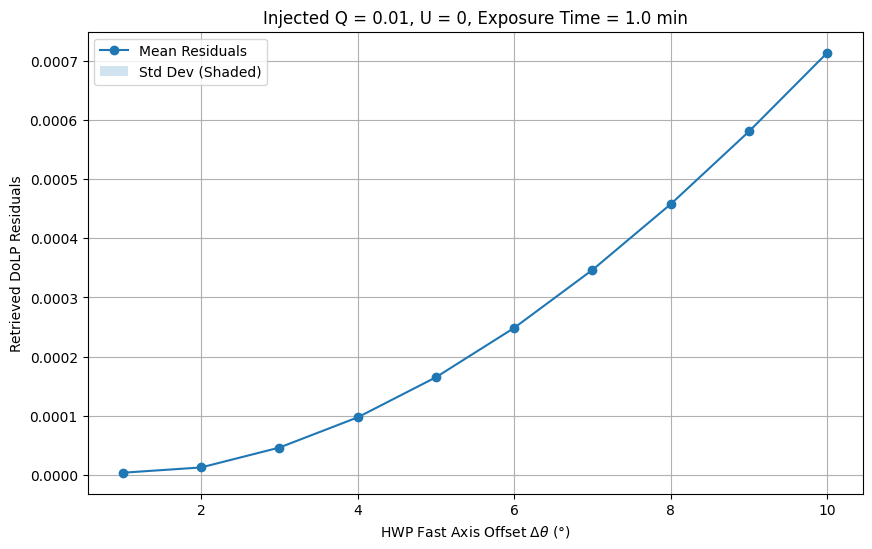

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../python/')
import angles
import instrument_mm

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST
matrix_noise_type = "additive"

# Fixed integration time and sub-integration time
t_int = 1 * 60  # 1 minute in seconds
sub_tint = 1  # 1 second
num_samples = 100

# Injected polarization
Q_injected = 0.01  # Injected Stokes Q
U_injected = 0  # Injected Stokes U
noise_percentage = 0  # Intensity noise
matrix_noise = 0  # Fixed matrix noise (1%)

# Varying HWP fast axis offset angles in degrees
delta_HWP_ang_values = np.arange(1, 11, 1)  # From 1 to 10 degrees
delta_HWP = 0.5
HWP_noise = 0  # Example noise for HWP retardance
num_trials = 50  # Number of trials per offset angle

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over HWP fast axis offset angles
    for delta_HWP_ang in delta_HWP_ang_values:
        residuals = []

        # Perform multiple trials for each offset angle
        for trial in range(num_trials):
            S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                ra=target["ra"], 
                dec=target["dec"], 
                observer_latitude=observer_latitude, 
                observer_longitude=observer_longitude, 
                jd_str=observation_date, 
                ut_start=observation_time, 
                t_int=t_int, 
                Q=Q_injected, 
                U=U_injected, 
                delta_HWP=delta_HWP,
                delta_HWP_ang=delta_HWP_ang,
                noise_percentage=noise_percentage,
                include_V=False,
                sub_tint=sub_tint,  # Sub-integration time in seconds
                TMT_matrix_noise=matrix_noise,
                NFIRAOS_matrix_noise=matrix_noise,
                MODHIS_matrix_noise=matrix_noise,
                observable="intensities",  # Or "single_difference" if needed
                sampled_steps=num_samples,
                matrix_noise_type=matrix_noise_type,
                HWP_noise=HWP_noise
            )
            
            # Calculate retrieved polarization
            Q_retrieved, U_retrieved = S_in_retrieved[1], S_in_retrieved[2]
            retrieved_polarization = np.sqrt(Q_retrieved**2 + U_retrieved**2)
            injected_polarization = np.sqrt(Q_injected**2 + U_injected**2)
            
            # Calculate absolute residuals
            residual = np.abs(injected_polarization - retrieved_polarization)
            residuals.append(residual)

        # Compute mean and standard deviation of residuals for this offset angle
        mean_residuals.append(np.mean(residuals))
        std_residuals.append(np.std(residuals))

        # Save the residuals as a .npy file
        filename = (
            f"{target['name']}_residuals_delta_HWP_ang_{delta_HWP_ang}_matrix_noise_{matrix_noise}_{matrix_noise_type}_"
            f"tint_{t_int}_sub_tint_{sub_tint}_readout_noise_{noise_percentage}_HWP_noise_{HWP_noise}.npy"
        )
        np.save(filename, np.array(residuals))
        print(f"Saved residuals to {filename}")

    # Plot the results for this target
    plt.figure(figsize=(10, 6))
    mean_residuals = np.array(mean_residuals)
    std_residuals = np.array(std_residuals)
    plt.plot(delta_HWP_ang_values, mean_residuals, '-o', label=f"Mean Residuals")
    plt.fill_between(delta_HWP_ang_values, mean_residuals - std_residuals, mean_residuals + std_residuals, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel(r"HWP Fast Axis Offset $\Delta \theta$ (°)")
    plt.ylabel("Retrieved DoLP Residuals")
    plt.title(
        # f"{target['name']} (Dec: {target['dec']}°)\n"
        f"Injected Q = {Q_injected}, U = {U_injected}, Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()


# Reading in Saved File

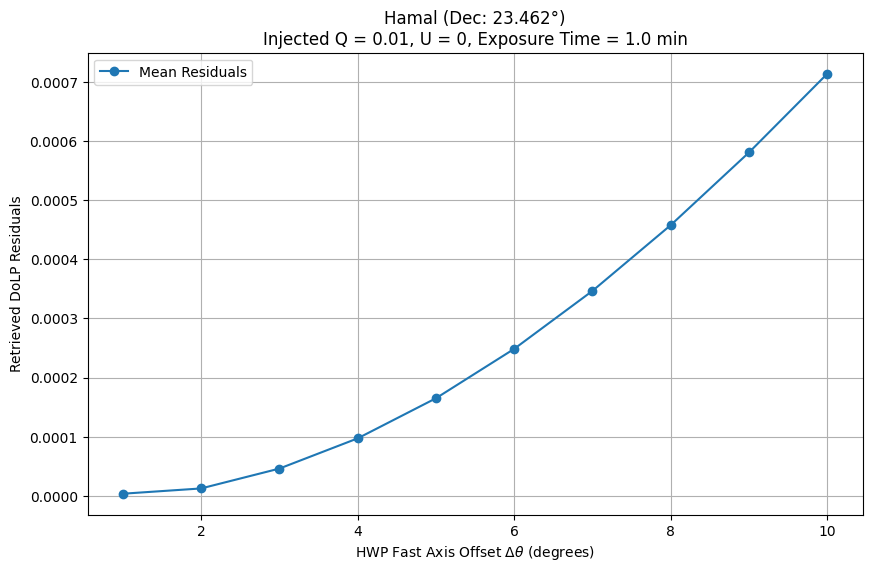

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
]

# Fixed parameters for plotting
matrix_noise = 0  # Fixed matrix noise
matrix_noise_type = "additive"
HWP_noise = 0.1  # Example noise for HWP retardance
t_int = 1 * 60  # Integration time (1 minute)
sub_tint = 1  # Sub-integration time
noise_percentage = 0  # Intensity noise
delta_HWP_ang_values = np.arange(1, 11, 1)  # HWP fast axis offset angles

# Loop over each target to generate plots
for target in targets:
    mean_residuals = []
    std_residuals = []

    for delta_HWP_ang in delta_HWP_ang_values:
        # Construct the filename based on the delta_HWP_ang
        filename = (
            f"{target['name']}_residuals_delta_HWP_ang_{delta_HWP_ang}_matrix_noise_{matrix_noise}_{matrix_noise_type}_"
            f"tint_{t_int}_sub_tint_{sub_tint}_readout_noise_{noise_percentage}_HWP_noise_{HWP_noise}.npy"
        )

        # Load residuals from file
        residuals = np.load(filename)
        mean_residuals.append(np.mean(residuals))
        std_residuals.append(np.std(residuals))

    # Plot the results for this target
    plt.figure(figsize=(10, 6))
    mean_residuals = np.array(mean_residuals)
    # std_residuals = np.array(std_residuals)

    plt.plot(delta_HWP_ang_values, mean_residuals, '-o', label=f"Mean Residuals")
    # plt.fill_between(delta_HWP_ang_values, mean_residuals - std_residuals, mean_residuals + std_residuals, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel(r"HWP Fast Axis Offset $\Delta \theta$ (degrees)")
    plt.ylabel("Retrieved DoLP Residuals")
    plt.title(
        # f"{target['name']} (Dec: {target['dec']}°)\n"
        f"Injected Q = 0.01, U = 0, Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()
